In [1]:
from utils import jl_to_list

samples = None
rows = jl_to_list('data/train_dataset.jl.gz')
if samples:
    rows = rows[:samples]

item_data = jl_to_list('data/item_data.jl.gz')

metadata = {x['item_id']:x for x in item_data}
all_items = list(metadata.keys())

y_true = [row['item_bought'] for row in rows]

test_dataset = jl_to_list('data/test_dataset.jl.gz')

In [2]:
import pandas as pd

df = pd.DataFrame(item_data)

In [3]:
df.head()

,item_id,title,domain_id,product_id,price,category_id,condition
0,111260,Casa Sola En Venta Con Gran Patio Solo Pago De...,MLM-INDIVIDUAL_HOUSES_FOR_SALE,None,1150000.00,MLM170527,new
1,871377,Resident Evil Origins Collection Nintendo Swit...,MLM-VIDEO_GAMES,15270800,1392.83,MLM151595,new
2,490232,Falda De Imitación Piel Negra,MLM-SKIRTS,None,350.00,MLM7697,new
3,1150706,Powercolor Red Devil Radeon Rx 580 8gb Gddr5,MLM-GRAPHICS_CARDS,None,3200.00,MLM9761,used
4,934912,Laptop Hp Nx6320 Core Duo Con Puerto Db9 Windo...,MLM-NOTEBOOKS,None,1599.00,MLM1652,used


In [4]:
df = df[df['item_id'].isin(y_true)]

In [5]:
df.head()

,item_id,title,domain_id,product_id,price,category_id,condition
31,297627,S10 10.1 Pulgadas Tablet Pc Android 8.0 8+128g...,MLM-TABLETS,None,1858.31,MLM82070,new
38,883687,2 Pack Tapete Foamy 3m2 61x61 8mm Fomy Gym Niñ...,MLM-BABY_SUPPLIES,None,399.00,MLM1887,new
141,153499,Bateria Xiaomi Mi Power Bank 2c 20000mah Quick...,MLM-PORTABLE_CELLPHONE_CHARGERS,None,999.00,MLM187617,new
169,1216469,Donde Habitan Los Ángeles,MLM-BOOKS,None,228.00,MLM1196,new
226,1283004,Bascula Digital 180kg Personal Cristal Templad...,MLM-BODYWEIGHT_SCALES,None,369.00,MLM5387,new


In [6]:
df['price'] = df['price'].astype(float)

In [7]:
df.isna().sum()

item_id            0
title              0
domain_id          0
product_id     50769
price              0
category_id        0
condition          0
dtype: int64

In [8]:
df.shape

(64928, 7)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 64928 entries, 31 to 2102267
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   item_id      64928 non-null  int64  
 1   title        64928 non-null  object 
 2   domain_id    64928 non-null  object 
 3   product_id   14159 non-null  object 
 4   price        64928 non-null  float64
 5   category_id  64928 non-null  object 
 6   condition    64928 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 4.0+ MB


In [10]:
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
item_id,64928,NaN,NaN,NaN,1.05459e+06,604944,33,534829,1.05383e+06,1.57878e+06,2.10224e+06
title,64928,59710,Xiaomi Redmi Note 7 (48 Mpx) Dual Sim 64 Gb Sp...,47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
domain_id,64928,3214,MLB-CELLPHONES,2576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
product_id,14159,6378,14141079,110,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,64928,NaN,NaN,NaN,2120.21,394535,0.01,55.9,129,255.153,1e+08
category_id,64928,4001,MLB1055,2576,NaN,NaN,NaN,NaN,NaN,NaN,NaN
condition,64928,3,new,64787,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'retina'

array([[<AxesSubplot:title={'center':'price'}>]], dtype=object)

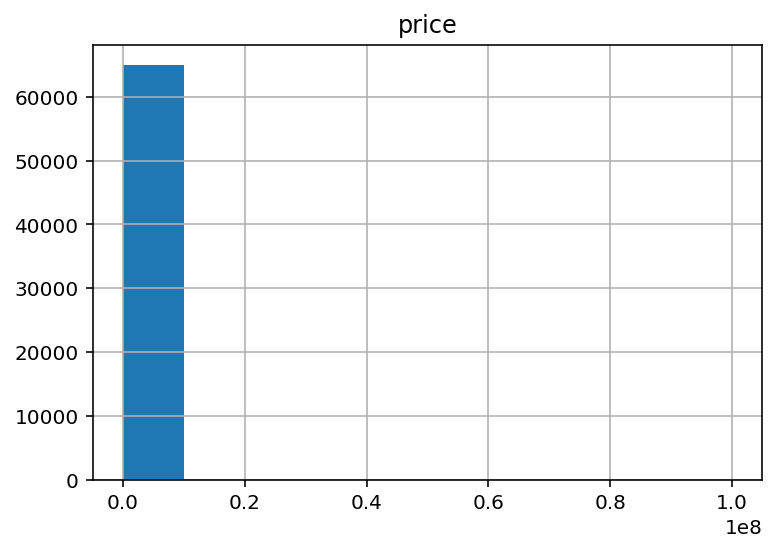

In [12]:
df[['price']].hist()

In [13]:
quantile_99 = df['price'].quantile(0.99)

In [28]:
quantile_99

3099.0

In [15]:
df = df[df['price'] < quantile_99]

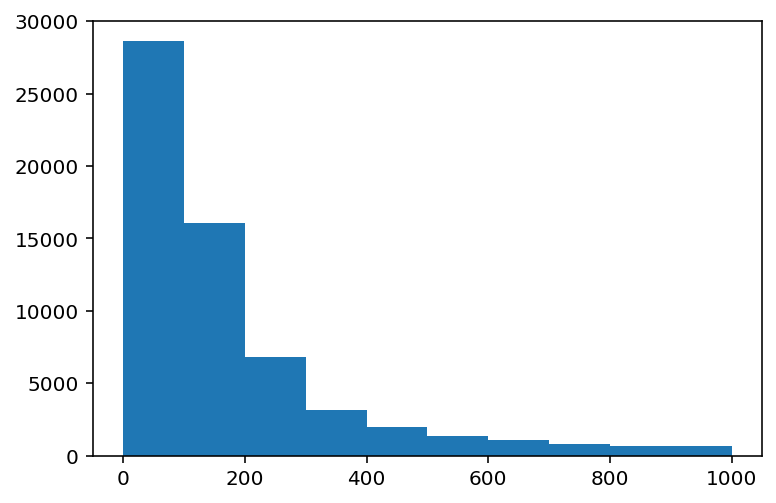

In [16]:
plt.hist(df['price'], range=(0, 1000))
plt.show()

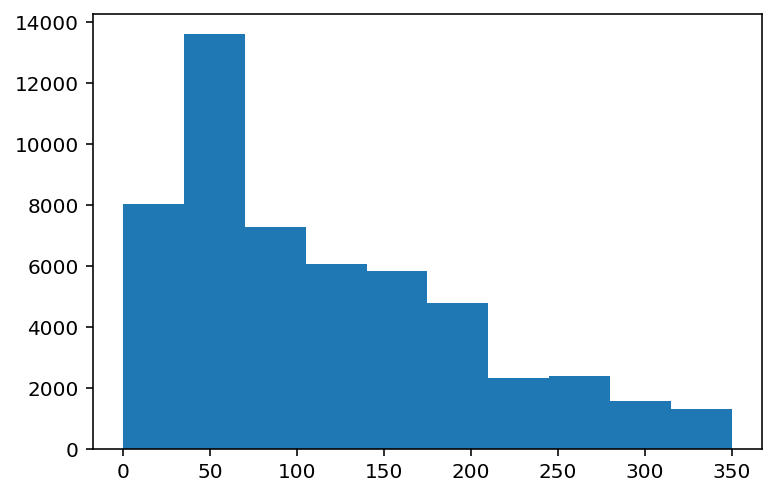

In [51]:
plt.hist(df['price'], range=(0, 350))
plt.show()

In [18]:
from statsmodels.distributions.empirical_distribution import ECDF
ecdf = ECDF(df['price'])

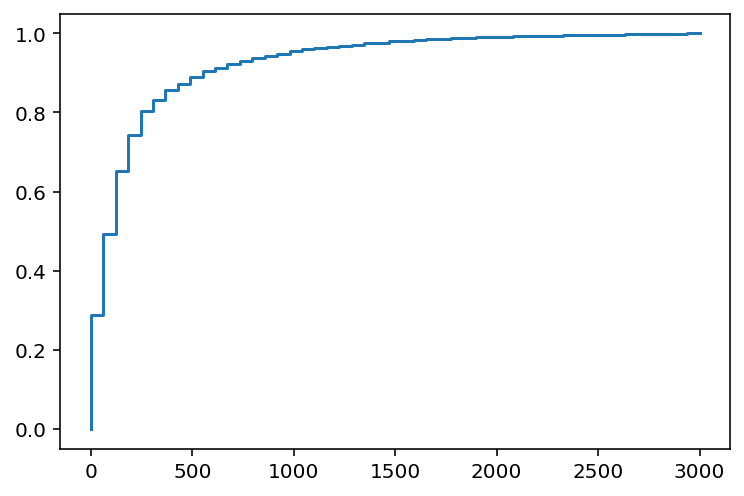

In [33]:
x = np.linspace(0, 3000)
y = ecdf(x)
plt.step(x, y)

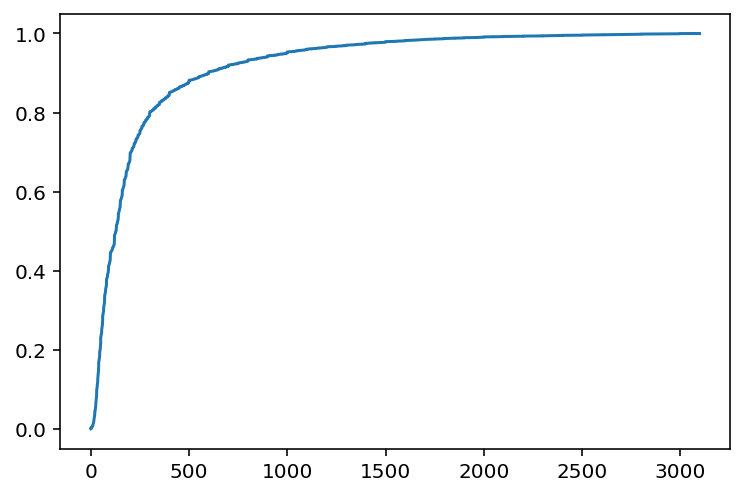

In [35]:
plt.plot(ecdf.x, ecdf.y)
plt.show()

In [34]:
ecdf(40) - ecdf(30)

0.0681945481702763

In [52]:
from tqdm.notebook import tqdm
from statsmodels.distributions.empirical_distribution import ECDF

class PriceBasedOrder(object):
    def __init__(self, sold_items, verbose=True):
        self.sold_items = sold_items
        self.ecdf = ECDF(sold_items['price'])
        self.verbose = verbose
        
    def fit(self, X=None, y=None):
        return self
    
    def predict(self, X=None):
        results = []
        for items in (tqdm(X) if self.verbose else X):
            scores = self._scores(items)
            results.append([item for _, item in sorted(zip(scores, items), reverse=True)])
        return results
    
    def _scores(self, items):
        scores = []
        for item in items:
            price = self.sold_items[self.sold_items['item_id'] == item]['price'].values[0]
            score = self.ecdf(price) - self.ecdf(price - 10)
            scores.append(score)
        return scores

Writing order_models.py


In [48]:
df['item_id'].values[:10]

array([ 297627,  883687,  153499, 1216469, 1283004, 1555217,  405618,
       1656113,  706474, 2082715], dtype=int64)

In [49]:
order = PriceBasedOrder(df)
order.predict([df['item_id'].values[:10]])

1858.31
399.0
999.0
228.0
369.0
299.0
450.0
1400.0
358.99
215.0
[ 297627  883687  153499 1216469 1283004 1555217  405618 1656113  706474
 2082715] [0.00043564849390087534, 0.0077172018919591245, 0.002971745083395483, 0.01226039332835449, 0.0036874533233757223, 0.011731391585760531, 0.0041853373164052465, 0.0017425939756037234, 0.007001493651979107, 0.011015683345780514]



[[1216469,
  1555217,
  2082715,
  883687,
  706474,
  405618,
  1283004,
  153499,
  1656113,
  297627]]

In [46]:
df.iloc[:10]

,item_id,title,domain_id,product_id,price,category_id,condition
31,297627,S10 10.1 Pulgadas Tablet Pc Android 8.0 8+128g...,MLM-TABLETS,None,1858.31,MLM82070,new
38,883687,2 Pack Tapete Foamy 3m2 61x61 8mm Fomy Gym Niñ...,MLM-BABY_SUPPLIES,None,399.00,MLM1887,new
141,153499,Bateria Xiaomi Mi Power Bank 2c 20000mah Quick...,MLM-PORTABLE_CELLPHONE_CHARGERS,None,999.00,MLM187617,new
169,1216469,Donde Habitan Los Ángeles,MLM-BOOKS,None,228.00,MLM1196,new
226,1283004,Bascula Digital 180kg Personal Cristal Templad...,MLM-BODYWEIGHT_SCALES,None,369.00,MLM5387,new
287,1555217,Producto Eficaz Para Eliminar Chinches De Cama...,MLM-PLAGUES_ULTRASONIC_REPELLENTS,None,299.00,MLM29880,new
325,405618,Biotin Plus Keratin 60 Tabletas Spring Valley,MLM-SUPPLEMENTS,15119344,450.00,MLM167994,new
353,1656113,Plancha Tazas Tlp 11oz Sublimación Sublimar Ta...,MLM-SCREEN_PRINTERS,15709438,1400.00,MLM120225,new
390,706474,Corrector Magnetico De Postura Terapia Con Ima...,MLM-BODY_SHAPERS,None,358.99,MLM7836,new
405,2082715,Mica Vidrio Templado Cristal Uv Samsung S10 S9...,MLM-CELLPHONE_TABLET_AND_GPS_SCREEN_PROTECTORS,None,215.00,MLM12953,new


In [ ]:
hist, bins = np.histogram(df['price'], bins=250)

In [ ]:
hist = hist/np.sum(hist)

In [ ]:
hist

In [ ]:
bins
